In [1]:
import sys
sys.path.insert(1, '..')
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sqlalchemy import create_engine

from snorkel.labeling import labeling_function

## Load Data

### DataFrame

In [2]:
## load the data by choosing a random 10% of the data
## is the data ordered? am I missing a large chunk due to my partial loading?
# p = 0.01
# responses = pd.read_csv('../data/moralmachine/SharedResponses.csv', skiprows=lambda i: i>0 and random.random() > p)

### SQL Engine

In [3]:
# access SQL DB with data
engine = create_engine("sqlite:///../data/moralmachine.db", echo=False)

In [4]:
# demo
# responses = pd.read_sql("SELECT * FROM sharedresponses ORDER BY RANDOM() LIMIT 100000", con=engine)
# responses.columns

In [5]:
# ## For viewing the possible values for each feature
# for feature in responses.columns:
#     print(feature)
#     print(responses[feature].unique())
#     print(responses[feature].unique().shape)

In [6]:
# ## What does a single user's session/response look like?
# responses_random = responses[responses['ScenarioTypeStrict'] == 'Random']
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     ## see a random user's session
# #     display(responses_random[responses_random['ExtendedSessionID'] == responses_random['ExtendedSessionID'].sample().values[0]])
    
#     ## see the user with nth most responses
#     n = 100
#     display(responses_random[responses_random['ResponseID'] == responses_random.groupby(by='ResponseID').size().sort_values(ascending=False).index[n]]) 

In [7]:
# ## group alternatives pairwise!
# # take only responses where both alternatives are present in the random sample - for a full sample, this step isn't necessary
# responses_grouped = responses.groupby(by='ResponseID').filter(lambda g: g.shape[0] < 2)
# responses_grouped.shape

## Data Exploration

In [8]:
# responses.describe()

## Snorkel Labeling
Using https://www.snorkel.org/use-cases/01-spam-tutorial

### Sample Data

In [9]:
# query random sample of responses grouped by ResponseID; only take responses for which both instances are present
sample_size = 1000000
query = """
    SELECT gc.session_count, sr.* FROM sharedresponses sr
    INNER JOIN (
        SELECT ExtendedSessionID, COUNT(DISTINCT ResponseID) AS session_count FROM sharedresponses
        WHERE UserID <> ''
        
        /* Get only full sessions. */
        GROUP BY ExtendedSessionID
            HAVING COUNT(DISTINCT ResponseID) LIKE 13
                AND COUNT(ResponseID) LIKE 26
        
        LIMIT {0:d}
    ) gc
        ON gc.ExtendedSessionID = sr.ExtendedSessionID
    ORDER BY sr.UserID
""".format(sample_size)
df = pd.read_sql(query, con=engine)
df

,session_count,ResponseID,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,...,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
0,13,C4yoxBdFMTE3tAjEu,1295349308_1000284909295010.0,1000284909295010,9,0,0,1,0,Fat,...,0,0,0,0,0,0,0,0,0,0
1,13,CDnbR339euts3x3c3,1295349308_1000284909295010.0,1000284909295010,6,0,1,0,0,Less,...,0,0,0,0,0,0,1,0,0,0
2,13,CMChvaNp5QZup4QBw,1295349308_1000284909295010.0,1000284909295010,2,0,0,1,0,Rand,...,1,0,0,1,0,0,0,0,0,0
3,13,CZ3BfpjubdHMdqq6z,1295349308_1000284909295010.0,1000284909295010,5,0,1,0,0,Young,...,0,0,0,0,0,0,0,0,0,0
4,13,C4yoxBdFMTE3tAjEu,1295349308_1000284909295010.0,1000284909295010,9,1,0,0,0,Fit,...,0,0,0,0,1,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544915,13,oNwjkhRzJpiBHfJNB,1708630306_9999973699194224.0,9999973699194220,4,0,1,0,0,Fit,...,0,0,0,0,1,1,0,0,0,0
1544916,13,zjbT9ydvthWaApyz3,1708630306_9999973699194224.0,9999973699194220,12,0,0,1,0,Old,...,0,0,0,0,0,0,0,0,0,0
1544917,13,nhxSBhkYqDjNqqeYu,1708630306_9999973699194224.0,9999973699194220,3,1,1,0,0,High,...,0,0,0,0,0,0,0,0,0,0
1544918,13,oNwjkhRzJpiBHfJNB,1708630306_9999973699194224.0,9999973699194220,4,1,1,0,0,Fat,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# size and other stuff
df.describe()

,session_count,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Saved,Man,...,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
count,1544920.0,1.544920e+06,1544920.0,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1544920.0,1.544920e+06,...,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06
mean,13.0,6.995973e+00,0.5,4.525270e-01,2.737365e-01,6.062489e-01,2.901300e+00,5.101623e-01,0.5,3.132848e-01,...,1.441291e-01,5.329079e-02,1.073615e-01,1.071712e-01,1.731565e-01,1.724141e-01,9.103190e-02,9.081765e-02,1.561356e-01,1.564081e-01
std,0.0,3.742443e+00,0.5,4.977414e-01,4.458755e-01,8.149253e-01,1.492986e+00,1.099643e+00,0.5,5.904199e-01,...,4.278764e-01,2.423233e-01,3.480164e-01,3.474571e-01,5.008922e-01,4.997909e-01,3.227842e-01,3.221732e-01,5.405188e-01,5.417887e-01
min,13.0,1.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,13.0,4.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,13.0,7.000000e+00,0.5,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.5,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,13.0,1.000000e+01,1.0,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,1.0,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,13.0,1.300000e+01,1.0,1.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,4.000000e+00,1.0,5.000000e+00,...,5.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


In [11]:
# number of users
df['UserID'].nunique()

51211

For comparison to Noothigattu et al., how many pairwise comparisons per voter in this sample dataset?

In [12]:
# number of pairwise comparisons per voter?
# = number of response IDs per voter
df.groupby('UserID')['ResponseID'].nunique().mean()

15.083868700083967

In [13]:
# number of scenarios
pd.DataFrame(df['ScenarioType'].value_counts()/df['ScenarioType'].value_counts().sum()).to_csv("../figures/data/freq_scenario.csv")
# frequency of each character count
characters = ['Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat']
pd.DataFrame(df[characters].sum()/df[characters].sum().sum(), columns=['frequency']).to_csv('../figures/data/freq_character.csv')

In [14]:
# user countries
freqs = df['UserCountry3'].value_counts()
pd.DataFrame(freqs/freqs.sum()).to_csv('../figures/data/freq_countries.csv')

In [15]:
df.iloc[:26,:].sort_values('ScenarioOrder')

,session_count,ResponseID,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,...,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
12,13,P3nEs8eAZDgegGQgL,1295349308_1000284909295010.0,1000284909295010,1,1,1,0,1,Low,...,0,0,0,0,0,0,0,0,0,0
9,13,P3nEs8eAZDgegGQgL,1295349308_1000284909295010.0,1000284909295010,1,0,1,0,2,High,...,0,0,0,0,0,0,0,0,0,0
2,13,CMChvaNp5QZup4QBw,1295349308_1000284909295010.0,1000284909295010,2,0,0,1,0,Rand,...,1,0,0,1,0,0,0,0,0,0
6,13,CMChvaNp5QZup4QBw,1295349308_1000284909295010.0,1000284909295010,2,1,0,0,1,Rand,...,0,1,0,1,0,0,0,0,0,0
17,13,mYhYL5Gxwpg53whqt,1295349308_1000284909295010.0,1000284909295010,3,1,0,0,0,Female,...,0,0,0,0,0,0,0,0,0,0
15,13,mYhYL5Gxwpg53whqt,1295349308_1000284909295010.0,1000284909295010,3,0,0,1,0,Male,...,1,0,0,0,0,0,0,0,0,0
22,13,rqrbkEMFStk5znStw,1295349308_1000284909295010.0,1000284909295010,4,1,0,1,0,Rand,...,0,0,0,0,0,0,0,0,0,0
18,13,rqrbkEMFStk5znStw,1295349308_1000284909295010.0,1000284909295010,4,0,0,0,0,Rand,...,0,0,0,0,0,1,0,0,0,0
3,13,CZ3BfpjubdHMdqq6z,1295349308_1000284909295010.0,1000284909295010,5,0,1,0,0,Young,...,0,0,0,0,0,0,0,0,0,0
7,13,CZ3BfpjubdHMdqq6z,1295349308_1000284909295010.0,1000284909295010,5,1,1,0,0,Old,...,0,0,0,0,0,0,0,0,0,0


Out of the variables above, these are the variables that vary within response pairs:
> 'NumberOfCharacters', 'DiffNumberOfCharacters', 'Saved', 'Template', 'DescriptionShown',
'LeftHand', 'UserCountry3', 'Man', 'Woman', 'Pregnant', 'Stroller',
'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman',
'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive',
'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog',
'Cat'

N.B. in each pair of responses, only one is the result of an intervention, and only one is saved. 

In [16]:
df[["ResponseID","Intervention","Saved"]].head()

,ResponseID,Intervention,Saved
0,C4yoxBdFMTE3tAjEu,0,1
1,CDnbR339euts3x3c3,0,0
2,CMChvaNp5QZup4QBw,0,1
3,CZ3BfpjubdHMdqq6z,0,1
4,C4yoxBdFMTE3tAjEu,1,0


### Preprocessing

First, let's convert to abstract features for ease of labeling.

In [17]:
import hmm.labeling.utils
importlib.reload(hmm.labeling.utils)
from hmm.labeling.utils import transform_abstract

ids = ['ResponseID', 'ExtendedSessionID', 'UserID']
df_i = df.set_index(ids, append=True, verify_integrity=True)
df_i.index = df_i.index.set_names(['UUID']+ids)
df_abstract = transform_abstract(df_i)
df_abstract.head()

,,,,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
UUID,ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
0,C4yoxBdFMTE3tAjEu,1295349308_1000284909295010.0,1000284909295010,13,9,0,1,0,Fat,Fitness,Fitness,Fit,Fat,...,0,0,0,0,0,3,0,1,1,1
1,CDnbR339euts3x3c3,1295349308_1000284909295010.0,1000284909295010,13,6,1,0,0,Less,Utilitarian,Utilitarian,More,Less,...,0,0,1,0,0,2,0,0,0,1
2,CMChvaNp5QZup4QBw,1295349308_1000284909295010.0,1000284909295010,13,2,0,1,0,Rand,Random,Random,,,...,0,1,0,0,0,5,0,1,1,1
3,CZ3BfpjubdHMdqq6z,1295349308_1000284909295010.0,1000284909295010,13,5,1,0,0,Young,Age,Age,Young,Old,...,0,0,0,0,0,4,0,0,0,1
4,C4yoxBdFMTE3tAjEu,1295349308_1000284909295010.0,1000284909295010,13,9,0,0,0,Fit,Fitness,Fitness,Fit,Fat,...,3,0,0,0,0,3,0,0,0,1


Now let's check our work.

In [18]:
sample = df_i.sample().index
df_i.loc[sample]

,,,,session_count,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,...,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Passenger,Law Abiding,Law Violating
UUID,ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
614772,3KaGriQ2Tqs3WmGGJ,-1812408514_3298757853.0,3298757853,13,12,0,1,0,2,Pets,Species,Species,Hoomans,...,0,0,0,0,0,1,3,False,False,False


In [19]:
df_abstract.loc[sample]

,,,,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
UUID,ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
614772,3KaGriQ2Tqs3WmGGJ,-1812408514_3298757853.0,3298757853,13,12,1,0,2,Pets,Species,Species,Hoomans,Pets,...,0,0,0,0,0,0,4,0,0,0


In [20]:
df_abstract.columns

Index(['session_count', 'ScenarioOrder', 'PedPed', 'Barrier', 'CrossingSignal',
       'AttributeLevel', 'ScenarioTypeStrict', 'ScenarioType', 'DefaultChoice',
       'NonDefaultChoice', 'DefaultChoiceIsOmission', 'NumberOfCharacters',
       'DiffNumberOFCharacters', 'Saved', 'Template', 'DescriptionShown',
       'LeftHand', 'UserCountry3', 'Intervene', 'Male', 'Female', 'Young',
       'Old', 'Infancy', 'Pregnancy', 'Fat', 'Fit', 'Working', 'Medical',
       'Homeless', 'Criminal', 'Human', 'Non-human', 'Passenger',
       'Law Abiding', 'Law Violating'],
      dtype='object')

First, select the fields that are unique to each scenario (the fields that vary within pairs of responses). Then split the dataset into two disjoint sets of alternatives: one in which an intervention occurs, and one in which there is no intervention.

In [21]:
ids = ["ResponseID", "ExtendedSessionID", "UserID"]
scenario_fields = [
    'Saved', 'NumberOfCharacters', 'DescriptionShown', 'LeftHand', 'Male', 'Female', 'Young', 'Old', 'Infancy', 'Pregnancy',
    'Fat', 'Fit', 'Working', 'Medical', 'Homeless', 'Criminal', 'Human',
    'Non-human', 'Passenger', 'Law Abiding', 'Law Violating'
]

df_abstract = df_abstract.reset_index(level='UUID')
sample_response = df_abstract.sample().index
intervention = df_abstract[df_abstract['Intervene'] == 1][scenario_fields]
no_intervention = df_abstract[df_abstract['Intervene'] == 0][scenario_fields]

print("Alternative w/ intervention:")
display(intervention.loc[sample_response])
print("Alternative w/o intervention:")
display(no_intervention.loc[sample_response])

Alternative w/ intervention:


,,,Saved,NumberOfCharacters,DescriptionShown,LeftHand,Male,Female,Young,Old,Infancy,Pregnancy,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
uhjdNyNMMyiWEfcts,611611461_5742142599051121.0,5742142599051120,1,2,0,0,2,0,0,0,0,0,...,0,1,0,0,0,2,0,0,1,0


Alternative w/o intervention:


,,,Saved,NumberOfCharacters,DescriptionShown,LeftHand,Male,Female,Young,Old,Infancy,Pregnancy,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
uhjdNyNMMyiWEfcts,611611461_5742142599051121.0,5742142599051120,0,2,0,1,1,0,0,0,0,0,...,0,0,0,1,0,2,0,0,0,0


Next, combine the datasets on response ID, separating the variable characteristics with suffixes.

In [22]:
df_endo = intervention.join(no_intervention, lsuffix='_int', rsuffix='_noint', how='inner')
df_endo.loc[sample_response]

,,,Saved_int,NumberOfCharacters_int,DescriptionShown_int,LeftHand_int,Male_int,Female_int,Young_int,Old_int,Infancy_int,Pregnancy_int,...,Fit_noint,Working_noint,Medical_noint,Homeless_noint,Criminal_noint,Human_noint,Non-human_noint,Passenger_noint,Law Abiding_noint,Law Violating_noint
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
uhjdNyNMMyiWEfcts,611611461_5742142599051121.0,5742142599051120,1,2,0,0,2,0,0,0,0,0,...,0,0,0,1,0,2,0,0,0,0


Get data for the columns from the raw data that _didn't_ change within response pairs. Remember to eliminate duplicate response pairs - now that we have a combined tuple for each pairwise comparison, they're no longer necessary.

In [23]:
df_exo = df_abstract[[col for col in df_abstract.columns if col not in scenario_fields]]
df_exo = df_exo.loc[~df_exo.index.duplicated(keep='first')]
df_exo.loc[sample_response]

,,,UUID,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,DefaultChoiceIsOmission,DiffNumberOFCharacters,Template,UserCountry3,Intervene
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,
uhjdNyNMMyiWEfcts,611611461_5742142599051121.0,5742142599051120,1045869,13,11,1,0,2,Low,Social Status,Social Status,High,Low,0,0,Mobile,HRV,0


Then join that data in with the combined endogenous variables to get a full tuple for each pairwise comparison presented to a user.

In [24]:
df_joined = df_exo.join(df_endo, how='inner').set_index(['UUID'], append=True, verify_integrity=True)
sample = df_joined.sample().index
df_joined.loc[sample]

,,,,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,...,Fit_noint,Working_noint,Medical_noint,Homeless_noint,Criminal_noint,Human_noint,Non-human_noint,Passenger_noint,Law Abiding_noint,Law Violating_noint
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
unPtd6APcWMHzvbW7,-172455258_2676861294.0,2676861294,444439,13,7,1,0,0,Less,Utilitarian,Utilitarian,More,Less,...,0,1,0,0,0,1,0,0,0,1


In [25]:
import hmm.labeling.utils
importlib.reload(hmm.labeling.utils)
from hmm.labeling.utils import pictofy
    
# works with abstract
pictofy(df_joined.loc[sample])

What should the self-driving car do? (ScenarioType: Utilitarian)

	    🚘 
	   |	\ 
	   v 	 v
	🔴🚸 	🚸🔴
	 NOINT	INT	
INT saves: 
['1 Male', '3 Female', '1 Young', '1 Fat', '1 Working', '1 Medical', '4 Human', '1 Non-human']
NOINT saves: 
['1 Female', '1 Working', '1 Human']



How much data did we lose with all these joins? Shouldn't be any - all we're doing is dividing the dataset in half.

In [26]:
print("df: {}".format(df.shape))
print("df_endo: {}".format(df_endo.shape))
print("df_exo: {}".format(df_exo.shape))
print("df_joined: {}".format(df_joined.shape))

df: (1544920, 42)
df_endo: (772460, 42)
df_exo: (772460, 16)
df_joined: (772460, 57)


Finally, let's make it easier to interpret the target variable. For each response, we know whether the user chose to save one set of characters (\_int) by intervention, or save another set (\_noint) by not intervening. Let's call that variable "Intervened" to indicate whether or not the user intervened (swerved the AV).

In [27]:
df_joined['Intervened'] = (df_joined['Saved_int'] == 1).astype(int)
df_joined = df_joined.drop(axis='columns', labels=['Saved_{}'.format(s) for s in ['int', 'noint']]+["Intervene"])
scenario_fields.remove('Saved')
df_joined.columns

Index(['session_count', 'ScenarioOrder', 'PedPed', 'Barrier', 'CrossingSignal',
       'AttributeLevel', 'ScenarioTypeStrict', 'ScenarioType', 'DefaultChoice',
       'NonDefaultChoice', 'DefaultChoiceIsOmission', 'DiffNumberOFCharacters',
       'Template', 'UserCountry3', 'NumberOfCharacters_int',
       'DescriptionShown_int', 'LeftHand_int', 'Male_int', 'Female_int',
       'Young_int', 'Old_int', 'Infancy_int', 'Pregnancy_int', 'Fat_int',
       'Fit_int', 'Working_int', 'Medical_int', 'Homeless_int', 'Criminal_int',
       'Human_int', 'Non-human_int', 'Passenger_int', 'Law Abiding_int',
       'Law Violating_int', 'NumberOfCharacters_noint',
       'DescriptionShown_noint', 'LeftHand_noint', 'Male_noint',
       'Female_noint', 'Young_noint', 'Old_noint', 'Infancy_noint',
       'Pregnancy_noint', 'Fat_noint', 'Fit_noint', 'Working_noint',
       'Medical_noint', 'Homeless_noint', 'Criminal_noint', 'Human_noint',
       'Non-human_noint', 'Passenger_noint', 'Law Abiding_noint',


Now choose which features to use:

In [28]:
# include user countries and other metadata or not? decided not - experts writing LFs are trying to decide most moral response, not predict what an individual from a certain background would do
# but if it helps generalization, technically useful... try both?
target = ["Intervened"]
features = ["Template", "UserCountry3"] + ["{}_{}".format(f, s) for f in scenario_fields for s in ["int", "noint"]]
cat_features = [
    "Template", "UserCountry3"
]
num_features = [f for f in features if f not in cat_features]
df_joined[features].head()

,,,,Template,UserCountry3,NumberOfCharacters_int,NumberOfCharacters_noint,DescriptionShown_int,DescriptionShown_noint,LeftHand_int,LeftHand_noint,Male_int,Male_noint,...,Human_int,Human_noint,Non-human_int,Non-human_noint,Passenger_int,Passenger_noint,Law Abiding_int,Law Abiding_noint,Law Violating_int,Law Violating_noint
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
C4yoxBdFMTE3tAjEu,1295349308_1000284909295010.0,1000284909295010,0,Desktop,MEX,3,3,0,0,1,0,2,2,...,3,3,0,0,0,1,0,1,1,1
CDnbR339euts3x3c3,1295349308_1000284909295010.0,1000284909295010,1,Desktop,MEX,5,2,0,0,1,0,1,0,...,4,2,1,0,0,0,0,0,1,1
CMChvaNp5QZup4QBw,1295349308_1000284909295010.0,1000284909295010,2,Desktop,MEX,5,5,0,0,1,0,1,2,...,5,5,0,0,0,1,1,1,0,1
CZ3BfpjubdHMdqq6z,1295349308_1000284909295010.0,1000284909295010,3,Desktop,MEX,4,4,0,0,1,0,0,0,...,4,4,0,0,0,0,0,0,1,1
Kvr4yzcYB8QAxykMg,1295349308_1000284909295010.0,1000284909295010,8,Desktop,MEX,2,2,0,0,1,0,2,0,...,2,2,0,0,0,0,0,0,1,1


Now explicitly type cast and deal with NA's or missing values:

In [29]:
# transform numerical data types
df_proc = df_joined.loc[:, features + target]

def transform_num(df, num_features):
    # convert to numeric, changing literals to NaN
    for f in num_features:
        df.loc[:, f] = pd.to_numeric(df.loc[:, f], errors='coerce')
    # are there any nan in the numerical features? usually just one
    nan = df[df[num_features].isna().any(axis=1)]
    print("Dropping these NaN:")
    display(nan)
    return df.dropna(axis=0, how='any', subset=num_features)

df_proc = transform_num(df_proc, num_features)
df_proc.columns

/opt/miniconda3/envs/hmm/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


Dropping these NaN:


,,,,Template,UserCountry3,NumberOfCharacters_int,NumberOfCharacters_noint,DescriptionShown_int,DescriptionShown_noint,LeftHand_int,LeftHand_noint,Male_int,Male_noint,...,Human_noint,Non-human_int,Non-human_noint,Passenger_int,Passenger_noint,Law Abiding_int,Law Abiding_noint,Law Violating_int,Law Violating_noint,Intervened
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
9XqeeDRQxdjXGtysP,-1132097515_1001529134,1001529134,182,,ROU,1,5,NaN,NaN,NaN,NaN,0,3,...,5,0,0,0,1,0,1,1,1,0
KQCdXCp4BcnqmmEky,-1132097515_1001529134,1001529134,184,,ROU,2,2,NaN,NaN,NaN,NaN,1,1,...,2,0,0,1,0,1,0,1,0,1
Ljhao6hyR8PAtMEP4,-1132097515_1001529134,1001529134,185,,ROU,2,2,NaN,NaN,NaN,NaN,0,2,...,2,0,0,1,0,1,0,1,0,1
MB9o7ub7KkvdWaD6j,-1132097515_1001529134,1001529134,186,,ROU,3,3,NaN,NaN,NaN,NaN,3,0,...,3,0,0,1,0,1,0,1,0,1
PRPQctv4Jzbxo7pMM,-1132097515_1001529134,1001529134,187,,ROU,1,1,NaN,NaN,NaN,NaN,1,1,...,1,0,0,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
o2i62HYZFCaiLSAeD,970197532_997534616,997534616,1541867,,MEX,1,1,NaN,NaN,NaN,NaN,1,1,...,1,0,0,1,0,1,1,1,0,1
pPGge5qxnWErpnWSs,970197532_997534616,997534616,1541868,,MEX,5,3,NaN,NaN,NaN,NaN,2,1,...,3,0,0,0,0,0,0,1,1,1
rccbnRp8ht7kyyXux,970197532_997534616,997534616,1541869,,MEX,2,2,NaN,NaN,NaN,NaN,0,0,...,2,2,0,1,0,1,0,1,0,1


Index(['Template', 'UserCountry3', 'NumberOfCharacters_int',
       'NumberOfCharacters_noint', 'DescriptionShown_int',
       'DescriptionShown_noint', 'LeftHand_int', 'LeftHand_noint', 'Male_int',
       'Male_noint', 'Female_int', 'Female_noint', 'Young_int', 'Young_noint',
       'Old_int', 'Old_noint', 'Infancy_int', 'Infancy_noint', 'Pregnancy_int',
       'Pregnancy_noint', 'Fat_int', 'Fat_noint', 'Fit_int', 'Fit_noint',
       'Working_int', 'Working_noint', 'Medical_int', 'Medical_noint',
       'Homeless_int', 'Homeless_noint', 'Criminal_int', 'Criminal_noint',
       'Human_int', 'Human_noint', 'Non-human_int', 'Non-human_noint',
       'Passenger_int', 'Passenger_noint', 'Law Abiding_int',
       'Law Abiding_noint', 'Law Violating_int', 'Law Violating_noint',
       'Intervened'],
      dtype='object')

### Train/Test Split

A standard train test split for testing:

In [30]:
import hmm.classification
importlib.reload(hmm.classification)
from hmm.classification import train_test_val_dev_split

def make_X_y(df):
    X = df.drop(labels=["Intervened"], axis='columns', inplace=False)
    y = df["Intervened"]
    return X, y

X, y = make_X_y(df_proc)
X_train, X_test, X_val, X_dev, y_train, y_test, y_val, y_dev = train_test_val_dev_split(X, y)
display(X_train.head())
display(y_train.head())
X.columns

,,,,Template,UserCountry3,NumberOfCharacters_int,NumberOfCharacters_noint,DescriptionShown_int,DescriptionShown_noint,LeftHand_int,LeftHand_noint,Male_int,Male_noint,...,Human_int,Human_noint,Non-human_int,Non-human_noint,Passenger_int,Passenger_noint,Law Abiding_int,Law Abiding_noint,Law Violating_int,Law Violating_noint
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
zMxxfgF5toKascmBC,-1560484671_5278886028275740.0,5278886028275740,990986,Mobile,DZA,2,2,0.0,0.0,1.0,0.0,0,0,...,2,2,0,0,0,0,1,0,0,0
JKxFztgS4cZc6iGx6,694893935_9451969873639508.0,9451969873639510,1482082,Desktop,NOR,5,5,0.0,0.0,1.0,0.0,2,2,...,5,5,0,0,0,0,1,0,0,0
ZnvDbZjQS24j6rXtg,-688785863_4707035014871508.0,4707035014871510,920524,Mobile,JPN,1,1,1.0,1.0,0.0,1.0,1,0,...,1,0,0,1,0,0,0,1,0,0
nbFBW7od8dNXobhCE,1228232883_2636069680125507.0,2636069680125510,434636,Desktop,AUS,5,4,0.0,0.0,0.0,1.0,3,1,...,3,4,2,0,1,0,1,1,1,0
w9F5iLSRTWPPRwxTK,-2023517918_2912710996256167.0,2912710996256170,511256,Mobile,BRA,2,2,0.0,0.0,1.0,0.0,1,0,...,2,2,0,0,1,0,1,0,1,0


ResponseID         ExtendedSessionID               UserID            UUID   
zMxxfgF5toKascmBC  -1560484671_5278886028275740.0  5278886028275740  990986     0
JKxFztgS4cZc6iGx6  694893935_9451969873639508.0    9451969873639510  1482082    1
ZnvDbZjQS24j6rXtg  -688785863_4707035014871508.0   4707035014871510  920524     1
nbFBW7od8dNXobhCE  1228232883_2636069680125507.0   2636069680125510  434636     1
w9F5iLSRTWPPRwxTK  -2023517918_2912710996256167.0  2912710996256170  511256     0
Name: Intervened, dtype: int64

Index(['Template', 'UserCountry3', 'NumberOfCharacters_int',
       'NumberOfCharacters_noint', 'DescriptionShown_int',
       'DescriptionShown_noint', 'LeftHand_int', 'LeftHand_noint', 'Male_int',
       'Male_noint', 'Female_int', 'Female_noint', 'Young_int', 'Young_noint',
       'Old_int', 'Old_noint', 'Infancy_int', 'Infancy_noint', 'Pregnancy_int',
       'Pregnancy_noint', 'Fat_int', 'Fat_noint', 'Fit_int', 'Fit_noint',
       'Working_int', 'Working_noint', 'Medical_int', 'Medical_noint',
       'Homeless_int', 'Homeless_noint', 'Criminal_int', 'Criminal_noint',
       'Human_int', 'Human_noint', 'Non-human_int', 'Non-human_noint',
       'Passenger_int', 'Passenger_noint', 'Law Abiding_int',
       'Law Abiding_noint', 'Law Violating_int', 'Law Violating_noint'],
      dtype='object')

### Labeling Model

Some sample labeling functions, constructed with the help of the effect sizes in the Moral Machine experiment.

In [32]:
import hmm.labeling.moralmachine as mm
import hmm.labeling.models
import hmm.labeling.utils
importlib.reload(hmm.labeling.moralmachine)
importlib.reload(hmm.labeling.models)
importlib.reload(hmm.labeling.utils)
import hmm.labeling.moralmachine as mm
import hmm.labeling.models
import hmm.labeling.utils

from hmm.labeling.models import Labeler
from snorkel.labeling import LFAnalysis

lfs = [
    mm.doctors,
    mm.utilitarian,
    mm.utilitarian_anthro,
    mm.action,
    mm.pedestrians,
    mm.females,
    mm.fitness,
    mm.status,
    mm.legal,
    mm.illegal,
    mm.youth,
    mm.elderly,
    mm.criminals,
    mm.homeless,
    mm.pets,
    mm.spare_strollers,
    mm.spare_pregnant
]

labeler = Labeler(lfs)
L_train, L_dev, L_val = labeler.label([X_train, X_dev, X_val])
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=y_dev.values).sort_values("Correct", ascending=False)


100%|██████████| 424419/424419 [06:15<00:00, 1130.45it/s]

100%|██████████| 26527/26527 [00:20<00:00, 1316.11it/s]

100%|██████████| 106105/106105 [01:37<00:00, 1083.47it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
action,3,[1],1.000000,1.000000,0.847024,14382,12145,0.542165
legal,8,"[0, 1]",0.784069,0.784069,0.713575,11617,9182,0.558536
females,5,"[0, 1]",0.519848,0.519848,0.434388,9353,4437,0.678245
pedestrians,4,"[0, 1]",0.542617,0.542617,0.526859,7695,6699,0.534598
utilitarian_anthro,2,"[0, 1]",0.366231,0.366231,0.312399,7469,2246,0.768811
illegal,9,"[0, 1]",0.542617,0.542617,0.526859,7285,7109,0.506114
youth,10,"[0, 1]",0.280846,0.280846,0.257662,5722,1728,0.768054
fitness,6,"[0, 1]",0.323557,0.323557,0.275531,4606,3977,0.536642
utilitarian,1,"[0, 1]",0.213971,0.213971,0.185396,4243,1433,0.747533
pets,14,"[0, 1]",0.164059,0.164059,0.136804,3452,900,0.793199


In [33]:
# using the validation set (since tuning is done)
analysis = LFAnalysis(L=L_val, lfs=lfs).lf_summary(Y=y_val.values)
analysis.to_csv("../figures/data/lfanalysis.csv")
# labeling density
pd.DataFrame(L_dev, columns=[lf.name for lf in lfs]).to_csv("../figures/data/mm-density.csv")

## Aggregation

Recall that there are no true labels for this problem - really, we're just measuring similarity of the heuristic labels to real voter's responses. 

**Baseline**: majority label voting.

In [34]:
from snorkel.labeling import MajorityLabelVoter

model_majority = MajorityLabelVoter()
preds_train = model_majority.predict(L=L_train)

**Label Model**: Snorkel aggregator. Chooses weights to combine the labeling functions based on learned conditional probabilities.

In [35]:
# cardinality is num classes
importlib.reload(hmm.labeling.models)

model_label = labeler.fit(L_train, Y_dev=y_dev.values, fit_params={'n_epochs': 200, 'log_freq': 50})
analysis = LFAnalysis(L=L_val, lfs=lfs).lf_summary(Y=y_val.values)
analysis['weight'] = pd.Series(model_label.get_weights(), index=[lf.name for lf in lfs])
analysis.to_csv('../figures/data/mm-weights.csv')
analysis.sort_values('Emp. Acc.')
# X[['Passenger_int', 'Passenger_noint', 'Law Abiding_int', 'Law Abiding_noint']]

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.,weight
elderly,11,"[0, 1]",0.256350,0.256350,0.236021,12130,15070,0.445956,0.666827
illegal,9,"[0, 1]",0.549154,0.549154,0.532614,28947,29321,0.496791,0.585872
pedestrians,4,"[0, 1]",0.549154,0.549154,0.532614,30802,27466,0.528626,0.603730
fitness,6,"[0, 1]",0.323444,0.323444,0.277744,18543,15776,0.540313,0.572663
action,3,[1],1.000000,0.999991,0.847151,57440,48665,0.541351,0.542164
legal,8,"[0, 1]",0.786626,0.786626,0.714801,46718,36747,0.559732,0.585695
homeless,13,"[0, 1]",0.090099,0.090099,0.071505,6025,3535,0.630230,0.633066
status,7,"[0, 1]",0.178201,0.178201,0.151784,12741,6167,0.673842,0.797942
females,5,"[0, 1]",0.520918,0.520918,0.433806,37583,17689,0.679965,0.728320
doctors,0,"[0, 1]",0.125866,0.125866,0.110824,9717,3638,0.727593,0.871110


How much does the label model improve on the majority voter?

In [36]:
from hmm.labeling.models import Labeler
importlib.reload(hmm.labeling.models)
from hmm.labeling.models import Labeler

for model in [model_majority, model_label]:
    Labeler.score(model, L_val, y_val)

MajorityLabelVoter() Vote Accuracy:            65.5
LabelModel() Vote Accuracy:            63.2


In [37]:
# what is the label model accuracy per scenario type?
# create a dataframe with scenariotype, gold label, probabilistic label, votes for each LF
## TODO REMOVE DEPRECATED SECOND ARG
preds_scenario = pd.DataFrame(L_val, columns=[lf.name for lf in lfs])
preds_scenario['scenario'] = df_joined.loc[X_val.index]['ScenarioType'].values
preds_scenario['actual'] = y_val.values
probs = labeler.model.predict_proba(L=L_val)
preds_scenario['pred'] = Labeler.probs_to_preds(probs)
preds_scenario.to_csv("../figures/data/mm-preds_scenario.csv")

### Eye Test - Debugging Label Model

Now, use the label model to create probabilistic labels for the dev set. Rounding off, create binary predictions.

In [37]:
from snorkel.analysis import get_label_buckets

threshold = 0.5
probs_dev = model_label.predict_proba(L=L_dev)
preds_dev = probs_dev >= threshold

Create label buckets for eyeball debugging (groups TP, FP, TN, FN).

In [38]:
# confusion matrix
print(labeler.get_confusion_matrix(L_dev, y_dev))
buckets = labeler.get_label_buckets(L_dev, y_dev)

TypeError: get_preds() takes 2 positional arguments but 3 were given

What is the accuracy for each scenario type?

In [ ]:
# false negatives
df_fn_dev = X_dev.iloc[buckets[(1, 0)]]
# false positives
df_fp_dev = X_dev.iloc[buckets[(0, 1)]]
df_n_dev = X_dev.iloc[np.concatenate([buckets[(1, 0)], buckets[(0, 1)]])]
# acc = 1 - Neg / Total for each scenario type
acc = 1 - df_joined.loc[df_n_dev.index, 'ScenarioType'].value_counts() / df_joined.loc[X_dev.index, 'ScenarioType'].value_counts()
acc.sort_values()

#### False Negatives
Here, the user chose to intervene, while the label model did not. 

In [ ]:
# get the corresponding posteriori probability for each false negative
df_fn_dev.loc[:,"probability"] = probs_dev[buckets[(1, 0)], 1]
# check out a few
pictofy(df_fn_dev.sample())

Which scenario types does the model tend to get wrong?

In [ ]:
df_joined.loc[df_fn_dev.index, 'ScenarioType'].value_counts().plot.pie()

#### False Positives
Here, the user chose not to intervene, but the label model did.

In [ ]:
# get the corresponding posteriori probability for each false positive
df_fp_dev.loc[:,"probability"] = probs_dev[buckets[(0, 1)], 1]
# check out a few
pictofy(df_fp_dev.sample(random_state=3))

In [ ]:
df_joined.loc[df_fp_dev.index, 'ScenarioType'].value_counts().plot.pie()

## Classification

https://www.snorkel.org/use-cases/01-spam-tutorial#5-training-a-classifier

### Featurization

Let's design a simple machine learning classifier for this problem, then test it on both the gold standard labels and the heuristic labels.

In [40]:
import hmm.classification
importlib.reload(hmm.classification)
from hmm.classification import Classifier

clf = Classifier(features, num_features, cat_features)

#### Training on Gold Labels

Using just the labels (no label model):

In [40]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

Test Accuracy: 70.5%


0.7047501818385273

#### Training on Heuristic Labels

Using the label model, filter out unlabeled points:

In [41]:
X_train_filtered, probs_train_filtered = labeler.filter_probs(X_train, L_train)
# check if filtered X_train has same columns
# X_train_filtered.columns == X_train.columns
# how many were filtered?
X_train.shape[0] - X_train_filtered.shape[0]

0

In [42]:
preds_train_filtered = Labeler.probs_to_preds(probs_train_filtered)
clf.fit(X_train_filtered, preds_train_filtered)
clf.score(X_test, y_test)

Test Accuracy: 63.9%


0.6386169081855313

### Grid Search Testing

**LF perturbations**

In [45]:
acc_full = Labeler.score(model_label, L_val, y_val)
lf_diffs = []
for lf in lfs:
    lfs_perturb = [l for l in lfs if l != lf]
    l = Labeler(lfs_perturb)
    L_train, L_dev, L_val = l.label([X_train, X_dev, X_val], verbose=False)
    lm = labeler.fit(L_train)
    acc_perturb = Labeler.score(lm, L_val, y_val, verbose=False)
    lf_diffs.append((lf.name, acc_full - acc_perturb))
    print("{}: {}".format(lf.name, acc_full - acc_perturb))
pd.DataFrame(lf_diffs, columns=['heuristic', 'value_added']).to_csv("../figures/data/mm-perturb.csv")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 34 is different from 32)

**Which models perform best?**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

for name, model in {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Log Reg": LogisticRegression(C=.001),
    "KNN": KNeighborsClassifier(3),
    "SVC Linear": SVC(kernel="linear", C=0.025),
    "SVC Nonlinear": SVC(gamma=2, C=1),
    "GP": GaussianProcessClassifier(1.0 * RBF(1.0)),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "RF": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "MLP": MLPClassifier(alpha=1, max_iter=1000),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}.items():
    print("## {} ##".format(name))
    clf = Classifier(features, num_features, cat_features, clf=model)
    
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test, verbose=False)
    print("Accuracy with gold labels: {}".format(acc))
    
    clf.fit(X_train_filtered, preds_train_filtered)
    acc = clf.score(X_test, y_test, verbose=False)
    print("Accuracy with heuristic labels: {}".format(acc))

## Random Forest ##
Accuracy with gold labels: 0.6969270720623242
Accuracy with heuristic labels: 0.6713373728630166
## Log Reg ##


/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with gold labels: 0.7052045011902186


/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with heuristic labels: 0.6623566327634711
## KNN ##


**How does performance change as the number of voters is increased?** 

In this case, evaluate performance voter-wise by splitting the data after stratifying by voter.

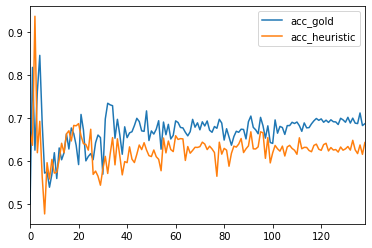

In [42]:
from sklearn.model_selection import train_test_split

data = []
users = df_proc.groupby(['UserID'])
a = np.arange(users.ngroups)
np.random.shuffle(a)
for i in list(range(1,100))+list(range(101,500,10)):
    n = i
#     print("## Testing N={}##".format(n))
    n_respondents = df_proc[users.ngroup().isin(a[:n])]
    # checking to make sure we're getting complete, single sessions
    # some users may have more than one session...
#     n_respondents.groupby('UserID').count().describe()
    X, y = make_X_y(n_respondents)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, stratify=X.index.get_level_values('ExtendedSessionID')
    )
#     y_train.groupby('ExtendedSessionID').count()
    L_train, L_test = labeler.label([X_train, X_test], verbose=False)
    lm = labeler.fit(L_train)
    Labeler.score(lm, L_test, y_test, verbose=False)
    X_train_filtered, probs_train_filtered = labeler.filter_probs(X_train, L_train)
    # baseline gold model accuracy
#     print("Gold accuracy")
    clf.fit(X_train, y_train)
    acc_gold = clf.score(X_test, y_test, verbose=False)
    # label model accuracy
#     print("LF accuracy")
    preds_train_filtered = Labeler.probs_to_preds(probs_train_filtered)
    clf.fit(X_train_filtered, preds_train_filtered)
    acc_lf = clf.score(X_test, y_test, verbose=False)
    data.append((n, acc_gold, acc_lf))
accs = pd.DataFrame(data, columns=["n_voters", "acc_gold", "acc_heuristic"])
accs.to_csv("../figures/data/mm-accs_voters.csv")
accs[['acc_gold', 'acc_heuristic']].plot()

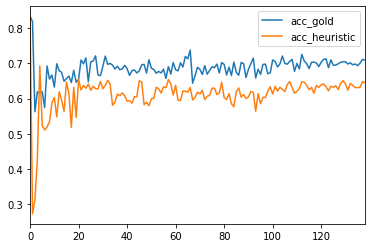

## Kim et al. Implementation

A replication of the model used by [Kim et al.](https://www.mendeley.com/viewer/?fileId=1b0d79d6-97a3-f7e5-3008-2e14db1a767b&documentId=3f4000f0-5830-358b-a8ea-b031e3ab5403) for estimating voter preferences. Will compare accuracy to Snorkel method.

Here, modeling _utilities_ as $u(\Theta_i) = w^\intercal F(\Theta_i)$, where $\Theta_y$ is the character vector for instance $y$ and $F : \Theta \to \Lambda$ is the mapping from the character vector to an abstract vector. This is accomplished by $F(\Theta) = A\Theta$, where $A$ is a binary matrix denoting the presence of abstract characterisitics.

### Benchmark 1

$u(\Theta) = w^{c\intercal}\Theta$, where $w^c \sim N_k(\mu, \sigma^2I)$.

In [67]:
## TODO: how to estimate w^c?